In [88]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt 
import librosa
import librosa.display
from IPython.display import Audio
import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings("ignore")


In [89]:
# Clean .DS_Store files from the directory structure because Apple sucks sometimes.
base_dir = 'kaggle/input'

# Traverse the directory structure
for root, _, files in os.walk(base_dir):
    for file in files:
        if file == '.DS_Store':
            file_path = os.path.join(root, file)
            os.remove(file_path)
            print(f"Deleted: {file_path}")

In [90]:
paths = []
labels = []
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        if label == 'store':
            print(label)
        labels.append(label.lower())
    if len(paths) == 2800:
        break
# print('Dataset is loaded')

In [91]:
len(paths)

2800

In [92]:
paths[:5]

['kaggle/input/YAF_disgust/YAF_date_disgust.wav',
 'kaggle/input/YAF_disgust/YAF_rag_disgust.wav',
 'kaggle/input/YAF_disgust/YAF_raise_disgust.wav',
 'kaggle/input/YAF_disgust/YAF_ditch_disgust.wav',
 'kaggle/input/YAF_disgust/YAF_door_disgust.wav']

In [93]:
labels[:5]

['disgust', 'disgust', 'disgust', 'disgust', 'disgust']

In [94]:
df = pd.DataFrame()
df['audio_paths'] = paths
df['labels'] = labels
df.head()
print(df['labels'])

0       disgust
1       disgust
2       disgust
3       disgust
4       disgust
         ...   
2795        sad
2796        sad
2797        sad
2798        sad
2799        sad
Name: labels, Length: 2800, dtype: object


In [95]:
df['labels'].value_counts()

labels
disgust    400
ps         400
happy      400
sad        400
neutral    400
fear       400
angry      400
Name: count, dtype: int64

<Axes: xlabel='labels', ylabel='count'>

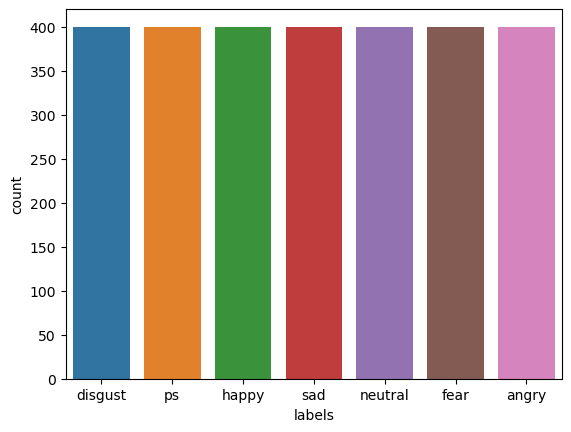

In [77]:
sns.countplot(data=df, x='labels')

In [78]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion,size=20)  
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectrogram(data, sr, emotion):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(11, 4))
    plt.title(emotion,size=20)  
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

0       disgust
1       disgust
2       disgust
3       disgust
4       disgust
         ...   
2795        sad
2796        sad
2797        sad
2798        sad
2799        sad
Name: labels, Length: 2800, dtype: object


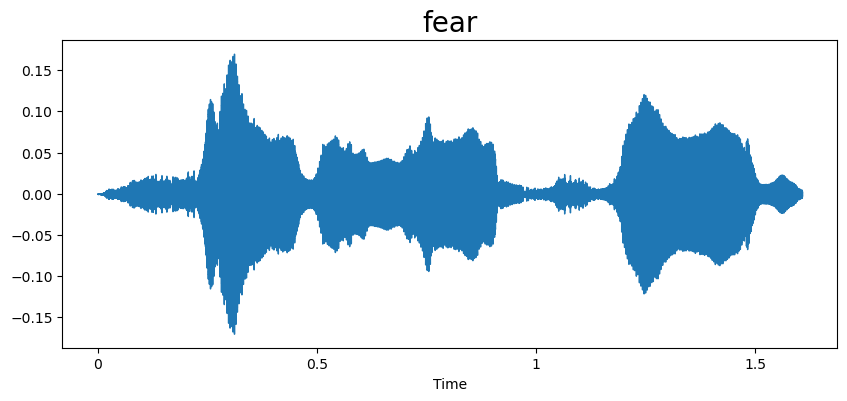

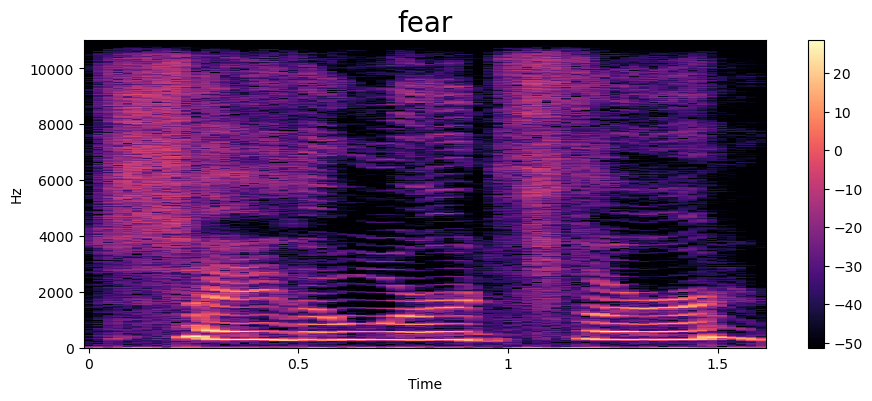

In [79]:
emotion = 'fear'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
print(df['labels'])
data, sampling_rate = librosa.load(path)    
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

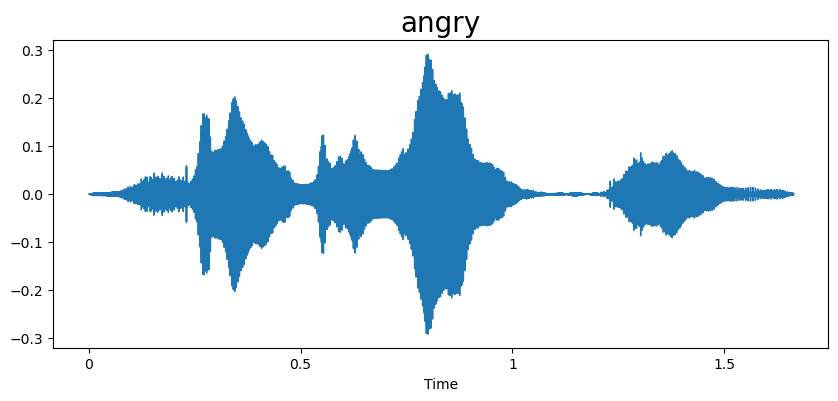

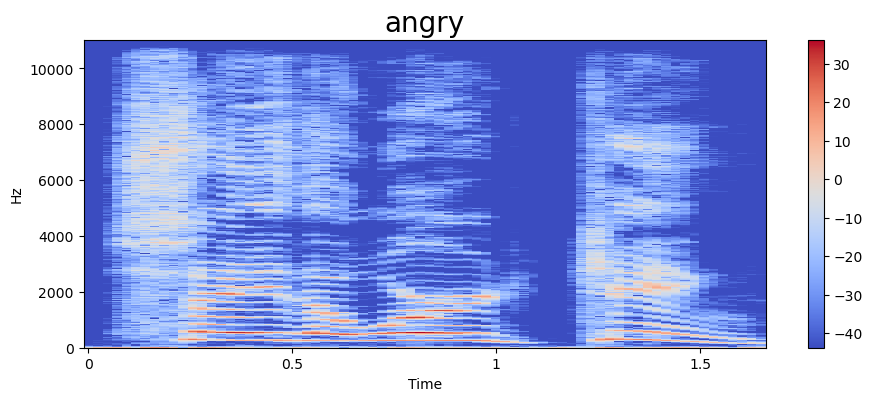

In [19]:
emotion = 'angry'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)    
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

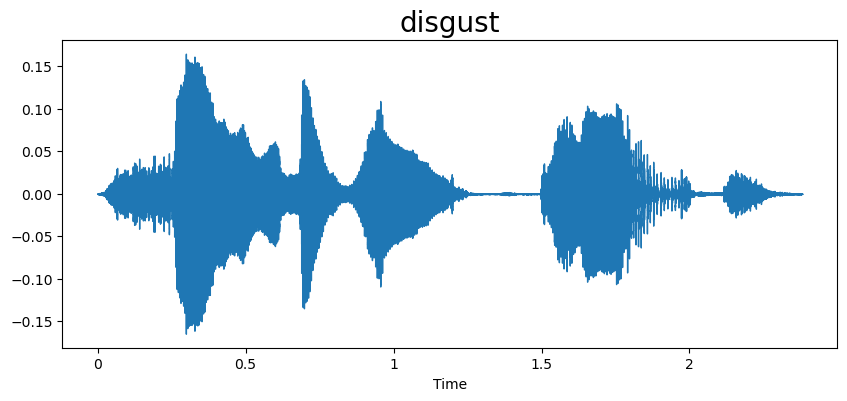

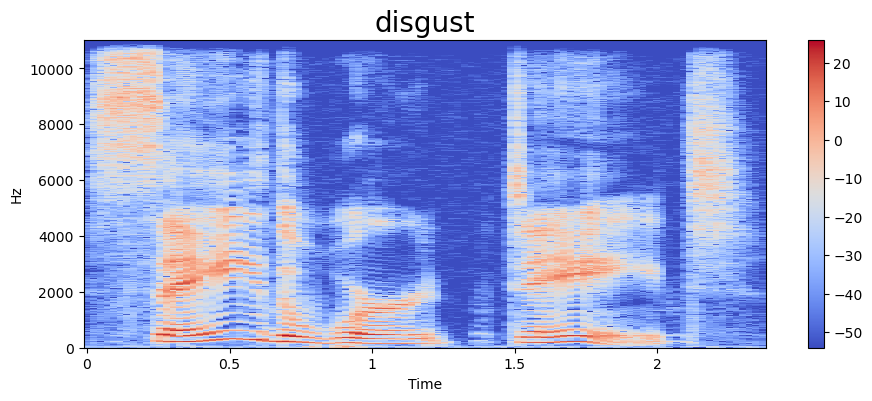

In [20]:
emotion = 'disgust'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)    
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

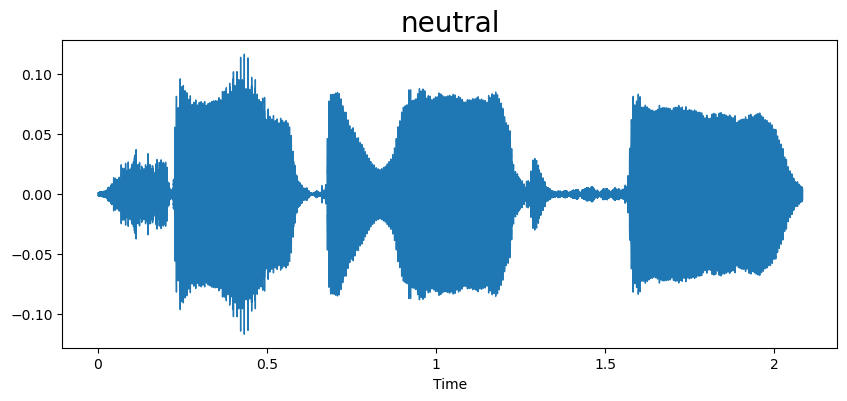

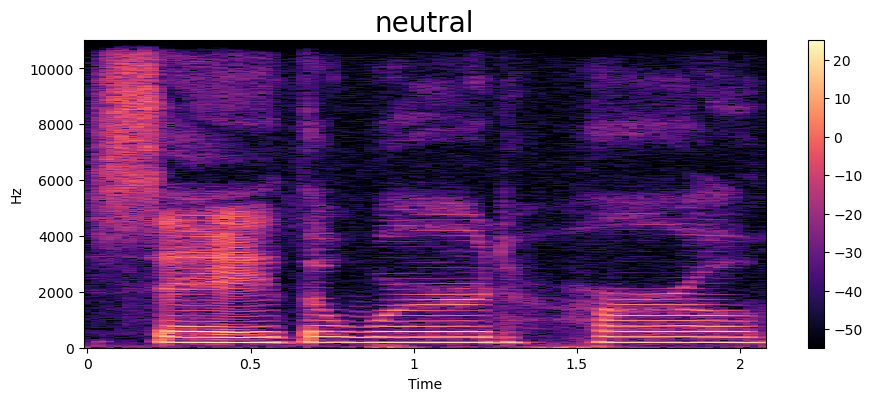

In [21]:
emotion = 'neutral'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)    
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

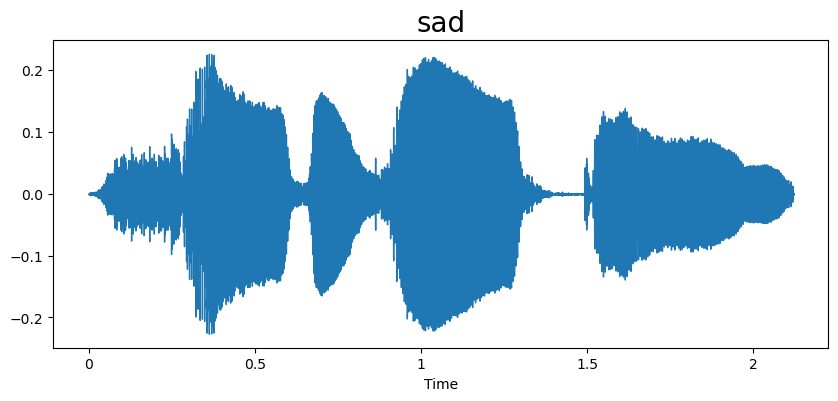

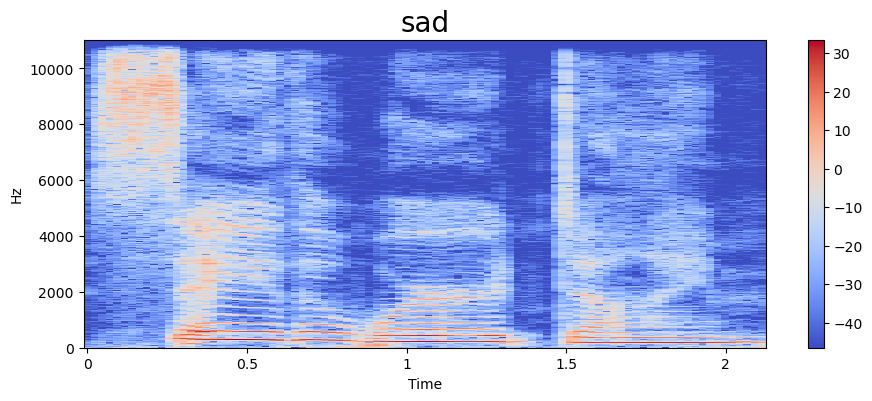

In [80]:
emotion = 'sad'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)    
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

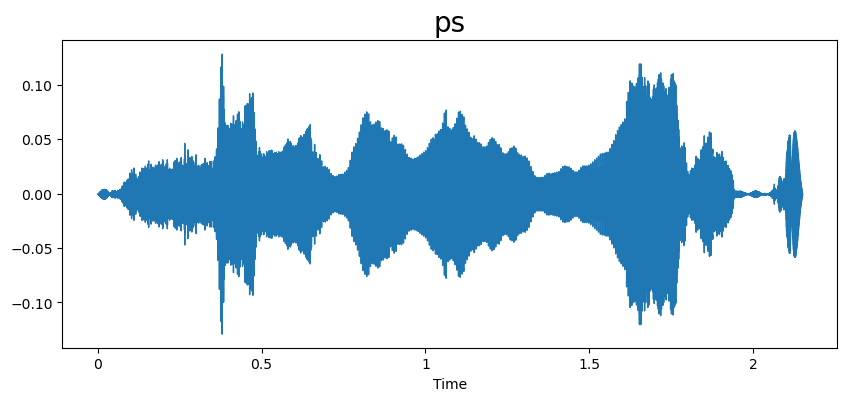

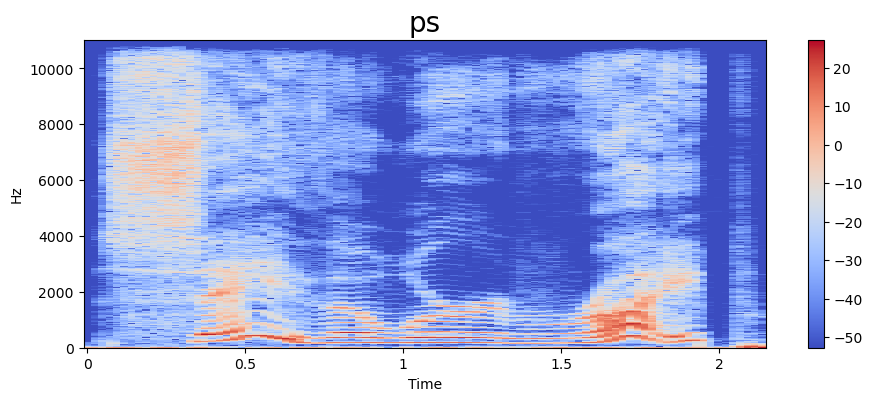

In [23]:
emotion = 'ps'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)    
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

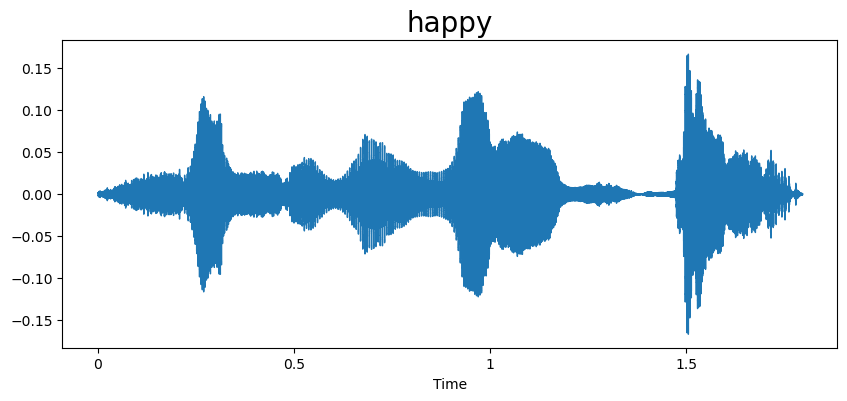

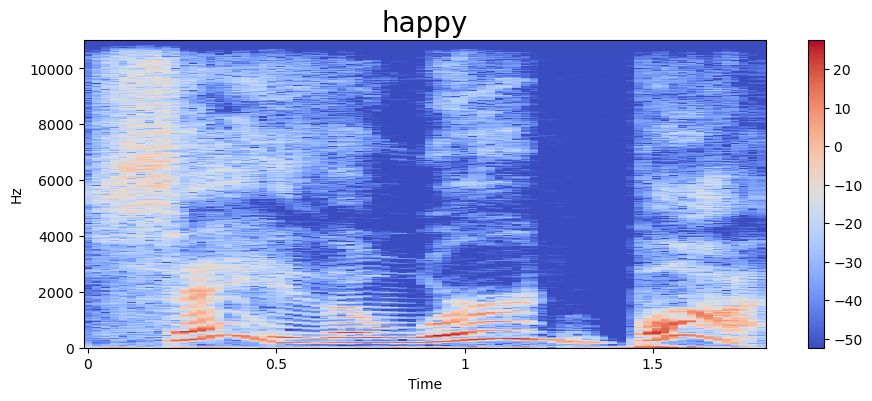

In [81]:
emotion = 'happy'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)    
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

## Create Custom Dataset Class

In [96]:
# Convert labels to integers
label_map = {label: idx for idx, label in enumerate(df['labels'].unique())}
print(df['labels'].dtype)
print(df['labels'].unique())
inverse_label_map = {i: label for label, i in label_map.items()}
df['labels'] = df['labels'].map(label_map)
# df.head(2)



object
['disgust' 'ps' 'happy' 'sad' 'neutral' 'fear' 'angry']


In [99]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length=32000):
        self.df = df
        self.processor = processor
        self.max_length = max_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['audio_paths']
        label = self.df.iloc[idx]['labels']
        speech, sr = librosa.load(audio_path, sr=16000, mono=True)
        speech = np.clip(speech, -1.0, 1.0)
        
        # pad or truncate the speech to the required length
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

        # preprocess the audio file
        inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, max_length=self.max_length)
        input_values = inputs.input_values.squeeze()

        return {'input_values': input_values, 'labels': torch.tensor(label, dtype=torch.long)}


In [100]:
# Split the data for train and test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [101]:
# Initialize the processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=7)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
train_dataset = SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

In [103]:
# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [104]:
from transformers import TrainingArguments, Trainer
# Set the training arguments
training_args = TrainingArguments(
    output_dir='./results',          
    evaluation_strategy='steps',
    eval_steps=500,
    save_strategy='epoch',   
    learning_rate=5e-5, 
    num_train_epochs=3,             
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    report_to=[],
    weight_decay=0.01,             
)

In [105]:
# Create functions for computing metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [106]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=420, training_loss=0.3715193612234933, metrics={'train_runtime': 539.1762, 'train_samples_per_second': 12.463, 'train_steps_per_second': 0.779, 'total_flos': 1.2201848064e+17, 'train_loss': 0.3715193612234933, 'epoch': 3.0})

In [107]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.01859986037015915, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 10.4452, 'eval_samples_per_second': 53.613, 'eval_steps_per_second': 3.351, 'epoch': 3.0}


## Test Predictions

In [108]:
import random
idx = random.randrange(0, len(test_dataset))

print('Original Label: ', inverse_label_map[int(test_dataset[idx]['labels'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('mps')

with torch.no_grad():
    outputs = model(input_values)
logits = outputs.logits

predicted_class = logits.argmax(dim=-1).item()
print('Predicted Label: ', inverse_label_map[predicted_class])


Original Label:  sad
Predicted Label:  sad


In [109]:
save_directory = 'SER_MODEL'
model.save_pretrained(save_directory)
processor.save_pretrained(save_directory)

[]

In [110]:
import json

# Save the label maps
with open('label_map.json', 'w') as f:
    json.dump(label_map, f)

with open('inverse_label_map.json', 'w') as f:
    json.dump(inverse_label_map, f)